### LSST AGN SC Regression Example

Gordon Richards and Weixiang Yu, Drexel University, February 2020

This notebook contains example code for learning how to use the AGN training set in the SciServer environment.  See https://github.com/RichardsGroup/LSST_training.

It specifically contains example code illustrating Pandas, Matplotlib, and SciKit-Learn tools that can be used to develop intitial photo-z algorithms for AGN in the LSST context.

Where possible and appropriate, we make reference to [Jake Vanderplas' Handbook for Data Science Python]( https://jakevdp.github.io/PythonDataScienceHandbook/).

In [1]:
#Load the various packages that we'll need
import numpy as np 
import pandas as pd #to enable the use of fancy data tables
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn #SciKit-Learn machine learning package for python
import zarr #See Setup.ipynb
pd.set_option('display.max_columns', 999)
from utils import * #See Setup.ipynb

#So that plots will be displayed inline
%matplotlib inline 

In [2]:
#See what versions of the software we are running
from platform import python_version
print(python_version())
print(np.version.version)
print(pd.__version__)
print(mpl.__version__)
print(sklearn.__version__)

3.7.8
1.19.2
1.1.3
3.3.2
0.23.2


In [3]:
## If using SciServer
# See Get_started.ipynb
init()

Start by loading up the quasar database into a [Pandas DataFrames](https://jakevdp.github.io/PythonDataScienceHandbook/03.00-introduction-to-pandas.html).

In [15]:
# get only DR16 QSO
qso_df = get_cat('s82Qso')
qso_df.head(5)

,train_id,ra,dec,spec_plate,spec_mjd,spec_fiberid,is_qso_final,z,source_z,specobjid,sdss_objid,psfmagerr_u,psfmagerr_g,psfmagerr_r,psfmagerr_i,psfmagerr_z,psfmag_u,psfmag_g,psfmag_r,psfmag_i,psfmag_z,extinction_u,extinction_g,extinction_r,extinction_i,extinction_z,dered_u,dered_g,dered_r,dered_i,dered_z,type,run,src2photo,src2gaia,gaia_id,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,spies_id,spies_ra,spies_dec,flux_auto_ch1,fluxerr_auto_ch1,class_star_ch1,flux_auto_ch2,fluxerr_auto_ch2,class_star_ch2,src2spies,ukidss_id,ay,aj,ah,ak,yapermag3,yapermag3err,japermag3,japermag3err,hapermag3,hapermag3err,kapermag3,kapermag3err,ukidss_pstar,ukidss_pgalaxy,src2ukidss,galex_id,fuv_mag,fuv_magerr,nuv_mag,nuv_magerr,src2galex,mpstype,psPm[0],psPm[1],psParallax,stdColor[0],stdColor[1],stdColor[2],stdColor[3],psFlux[u],psFlux[g],psFlux[r],psFlux[i],psFlux[z],class,gal_subclass,s82LSST,s82SDSS,sdss_lcN
0,0,309.2164,0.516741,1117,52885.0,356,1,1.641482,DR6Q_HW,1.257728e+18,8647474692728161280,0.031342,0.011038,0.014122,0.015842,0.048335,20.32299,20.16837,20.07710,19.77096,19.69925,0.381036,0.280362,0.203342,0.154188,0.109321,19.94195,19.88801,19.87376,19.61677,19.58993,6,106,0.072612,0.039874,4231211839387175424,1.231243,1.208207,-0.665619,3.160284,1.479964,1.664234,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,433796596990,0.089510,0.065709,0.042722,0.026609,19.325617,0.098304,18.882778,0.115129,18.259062,0.178485,17.800070,0.148309,5.262303e-02,0.947215,0.257996,<NA>,NaN,NaN,NaN,NaN,NaN,<NA>,-0.665619,1.479964,1.231243,0.05394,0.01425,0.25699,0.02684,25982.198589,26962.891720,33815.371339,44828.061729,48635.957944,s82Qso,None,1,1,54
1,1,309.2194,-0.479245,1117,52885.0,304,1,0.930411,DR6Q_HW,1.257714e+18,8647475120614278144,0.024440,0.006830,0.007038,0.010528,0.030004,20.74151,20.39063,20.12772,20.14267,19.90907,0.685644,0.504490,0.365898,0.277450,0.196715,20.05587,19.88614,19.76183,19.86522,19.71235,6,206,0.050114,0.059315,4226575164493552128,-0.019745,0.554584,-0.513296,0.941636,0.313089,0.679704,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,433863658375,0.147035,0.107939,0.070178,0.043710,18.807596,0.060388,17.898998,0.048343,17.426260,0.063209,16.787697,0.054704,5.262303e-02,0.947215,0.149148,6379430435810709504,NaN,NaN,21.093075,0.240537,1.100549,1,-0.513296,0.313089,-0.019745,0.16973,0.12431,-0.10339,0.15287,17663.977528,18335.145244,32274.469694,31825.497722,40029.683101,s82Qso,None,1,1,59
2,2,309.2220,-0.160658,1117,52885.0,302,1,1.775506,DR6Q_HW,1.257713e+18,8647475121151149056,0.014701,0.005218,0.006074,0.006600,0.023517,20.22258,20.10596,19.98231,19.65110,19.64488,0.483065,0.355435,0.257791,0.195475,0.138594,19.73952,19.75052,19.72452,19.45563,19.50629,6,206,0.023886,0.065399,4226625226631362560,-0.400886,0.740825,-0.196442,2.120447,-2.177161,1.401930,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,433841002105,0.113455,0.083288,0.054151,0.033727,19.169900,0.102561,18.693764,0.095908,18.334024,0.177777,17.441616,0.108151,1.714368e-04,0.999819,0.056143,<NA>,NaN,NaN,NaN,NaN,NaN,<NA>,-0.196442,-2.177161,-0.400886,-0.01100,0.02600,0.26889,-0.05066,28501.385092,29576.122657,36901.303832,50062.466916,51148.877388,s82Qso,None,1,1,49
3,3,309.2296,0.171063,1117,52885.0,354,1,1.110641,DR6Q_HW,1.257728e+18,8647474692191290368,0.018865,0.006770,0.008106,0.011149,0.050139,19.44578,19.42037,19.31383,19.41686,19.44050,0.426967,0.314159,0.227854,0.172775,0.122499,19.01881,19.10621,19.08597,19.24408,19.31800,6,106,0.073788,0.020377,4231137828510030336,0.975206,0.943810,1.561449,2.184165,2.870286,2.162752,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,433816504832,0.100299,0.073630,0.047872,0.029816,19.053074,0.107903,19.285357,0.198457,18.067146,0.156423,17.129730,0.093723,9.472145e-01,0.052623,0.248786,<NA>,NaN,NaN,NaN,NaN,NaN,<NA>,1.561449,2.870286,0.975206,-0.08740,0.02024,-0.15811,-0.07392,58302.017211,60492.505873,68308.787979,62120.391275,61798.356728,s82Qso,None,1,1,50
4,4,309.2387,0.028991,1117,52885.0,301,1,0.442569,DR6Q_HW,1.257713e+18,864747469

What columns are available to us?

In [16]:
qso_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83881 entries, 0 to 83880
Data columns (total 92 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   train_id          83881 non-null  Int64  
 1   ra                83881 non-null  float64
 2   dec               83881 non-null  float64
 3   spec_plate        83881 non-null  Int64  
 4   spec_mjd          83881 non-null  float64
 5   spec_fiberid      83881 non-null  Int64  
 6   is_qso_final      83881 non-null  Int64  
 7   z                 83881 non-null  float64
 8   source_z          83881 non-null  object 
 9   specobjid         83881 non-null  float64
 10  sdss_objid        78230 non-null  Int64  
 11  psfmagerr_u       78230 non-null  float64
 12  psfmagerr_g       78230 non-null  float64
 13  psfmagerr_r       78230 non-null  float64
 14  psfmagerr_i       78230 non-null  float64
 15  psfmagerr_z       78230 non-null  float64
 16  psfmag_u          78230 non-null  float6

For now, let's just use the colors as indicated in the following cell.

In [36]:
collist = ['ra','dec','stdColor[0]','stdColor[1]','stdColor[2]','stdColor[3]','z']
train_df = qso_df[collist].dropna()

In [37]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78230 entries, 0 to 83880
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ra           78230 non-null  float64
 1   dec          78230 non-null  float64
 2   stdColor[0]  78230 non-null  float64
 3   stdColor[1]  78230 non-null  float64
 4   stdColor[2]  78230 non-null  float64
 5   stdColor[3]  78230 non-null  float64
 6   z            78230 non-null  float64
dtypes: float64(7)
memory usage: 4.8 MB


SciKit-Learn uses a convention where "X" is a multi-dimensional matrix of features (columns) for each object (rows).  In the case of regression "y" are the "answers", which here means the redshift.

We'll next build both "y" and "X" (the order is important) from our training dataframe.  

"y" is just the values of redshift.

Once the label array, y, is defined, we drop that information from the dataframe (otherwise, we'd be cheating!) and define "X".  Let's also drop RA and Dec.

In [38]:
y = train_df['z'].values
y

array([1.641482, 0.930411, 1.775506, ..., 1.840065, 2.448845, 0.329833])

In [39]:
X = train_df.drop(['ra','dec','z'],axis=1).values
X
print(X.shape)

(78230, 4)


Let's take a look at the data.

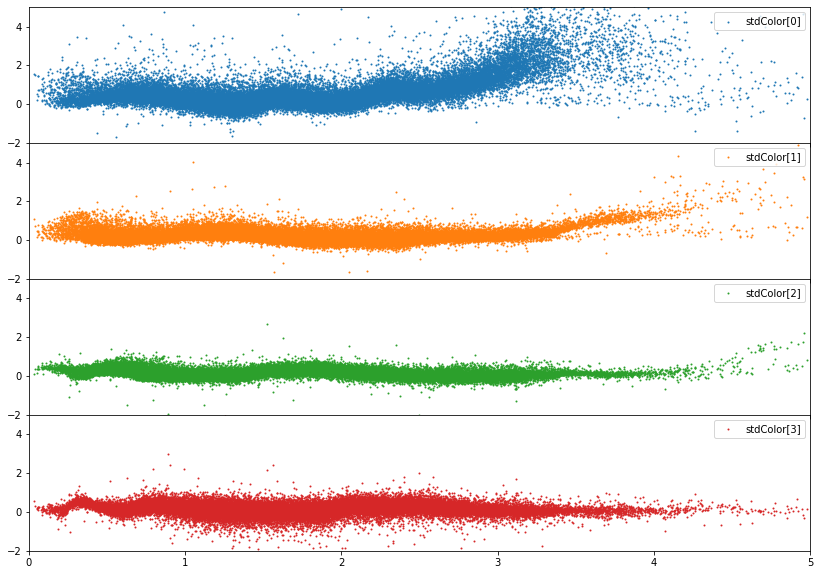

In [40]:
fig, axarr = plt.subplots(4, sharex='col',gridspec_kw={'hspace':0, 'wspace':0},figsize=(14,10))
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i,ax in enumerate(axarr):
    ax.scatter(y,X[:,i], s=1, color=cycle[i], label=train_df.columns[i+2])
    ax.legend(loc='upper right')
    ax.set_ylim([-2,5])
    ax.set_xlim([0,5])

We are going to try to use the fact that the "shape" of this distribution with redshift is different for each color to predict the redshift of new objects that lack spectroscopy.

In the classification example, the Random Forest worked pretty well, so let's try the [Random Forest Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html).

In [41]:
from sklearn.ensemble import RandomForestRegressor

In [42]:
model = RandomForestRegressor(n_estimators=100,random_state=42)

In [44]:
from sklearn.model_selection import cross_val_predict
y_pred = cross_val_predict(model, X, y, cv=5, n_jobs=-1)

Let's plot the known redshift vs. the predicted redshift to see how we did.

Text(0, 0.5, 'Photo-z')

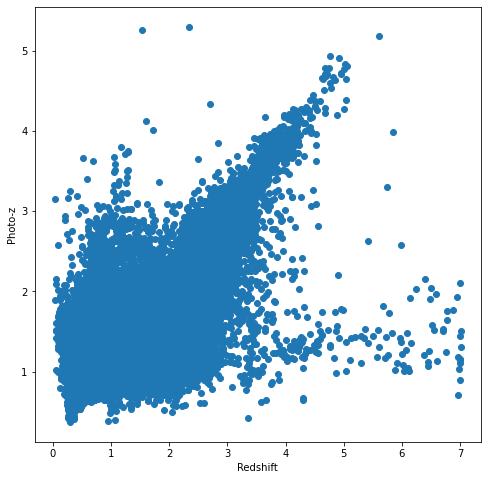

In [46]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(y,y_pred)
ax.set_xlabel('Redshift')
ax.set_ylabel('Photo-z')

This looks terrible!  But it really is not as bad as it seems (as we can see by making a better plot).

In [47]:
#Put the known redshift and predicted redshift into a new Pandas dataframe.
df = pd.DataFrame({'Redshift':y,'Photo-z':y_pred})

/home/idies/miniconda3/envs/lsst_train/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


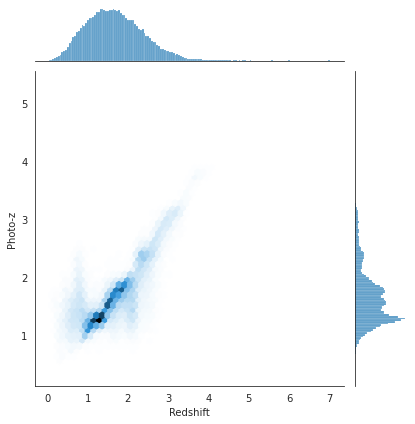

In [48]:
#Make a fancy plot
import seaborn as sea
with sea.axes_style('white'):
    sea.jointplot('Redshift','Photo-z',df, kind='hex')

While we can certainly do a lot better, most of the objects have their redshifts well predicted, which is also illustrated by the following histogram.

Text(0.5, 0, 'z_{spec} - z_{phot}')

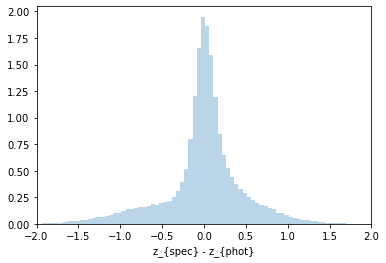

In [49]:
#Plot a histogram of the results
kwargs = dict(histtype='stepfilled', alpha=0.3, density=True, bins=200)
plt.hist(y-y_pred, **kwargs);
plt.xlim(-2,2)
plt.xlabel('z_{spec} - z_{phot}')

We might like to know which features contributed the most to the accuracy.  This will be especially true when we start including novel features like DCR.

In this case that information is stored in the `feature_importances_`.

In [50]:
model.fit(X,y)
model.feature_importances_

array([0.42534123, 0.21183965, 0.21911072, 0.1437084 ])

We see that $u-g$ contributes the most (by far), followed by $r-i$, then $g-r$, and finally $i-z$.

Ultimately our algorithm (likely multiple algorithms) will need to produce full PDFs and ideally will handle both the LLAGN and luminous quasars.